### Import modules

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw

from scipy.stats import linregress

In [2]:
# mini_G = nx.read_gml('./Graphs/mini_graph.gml')
vocab_G = nx.read_gml('./Graphs/corpus_vocab.gml')
len(vocab_G)

11578

### Degree distribution

In [3]:
def degree_distro(G: nx.DiGraph, name) -> (float, float):
    """Get the degree exponent and plot the degree distribution of a network
    Parameters:
        G (nx.DiGraph): a directed network
        name (str): the name of the network
    Returns:
        float: the in-degree exponent
        float: the out-dgree exponent"""
    
    in_deg = np.array([i for i in dict(vocab_G.in_degree()).values() if i > 0])
    out_deg = np.array([i for i in dict(vocab_G.out_degree()).values() if i > 0])
    
    k_min, k_max = min(min(in_deg), min(out_deg)), max(max(in_deg), max(out_deg))
    
    # get log bins and density
    bin_edges = np.logspace(np.log10(k_min), np.log10(k_max), num = 25)
    in_density, _ = np.histogram(in_deg, bins = bin_edges, density = True)
    out_density, _ = np.histogram(out_deg, bins = bin_edges, density = True)
    
    # calculate degree exponent
    in_res = powerlaw.Fit(in_deg, discrete = True)
    print('In-degree gamma:', in_res.power_law.alpha)
    out_res = powerlaw.Fit(out_deg, discrete = True)
    print('Out-degree gamma:', out_res.power_law.alpha)
    
    log_be = np.log10(bin_edges)
    x = 10 ** ((log_be[: -1] + log_be[1 :]) / 2)
    
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.loglog(x, in_density, marker = 'o', ls = 'none', color = '#1c39bb', label = 'In-degree')
    plt.loglog(x, out_density, marker = '^', ls = 'none', color = '#ff8b00', label = 'Out-degree')
    plt.title('{} Network Degree Distribution'.format(name))
    plt.xlabel('Degree k')
    plt.ylabel('Density p(k)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend()
    plt.show()
    plt.close()
    
    return in_res.power_law.alpha, out_res.power_law.alpha

Calculating best minimal value for power law fit
In-degree gamma: 2.116580172099942
Calculating best minimal value for power law fit
Out-degree gamma: 2.196581597356233


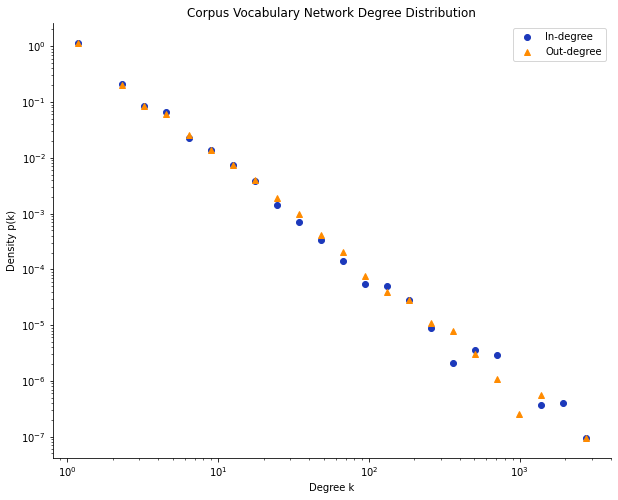

In [4]:
in_deg_exp, out_deg_exp = degree_distro(vocab_G, 'Corpus Vocabulary')

In [5]:
def in_out_degrees(G: nx.DiGraph, in_deg: list, out_deg: list, name, threshold = 700) -> None:
    """Plot the in-degrees vs out-degrees of a directed network
    Parameters:
        G (nx.DiGraph): the network
        in_deg (list): the in-degrees
        out_deg (list): the out-degrees
        name (str): the name of the network
        threshold (int): the min degree for a point to be annotated (default: 700)
    Returns:
        None"""
    
    fig = plt.figure(figsize = (10, 8))
    plt.scatter(in_deg, out_deg, alpha = 0.7, color = '#552583')
    
    for i in G.nodes:
        if G.in_degree(i) > threshold or G.out_degree(i) > threshold:
            plt.annotate(i, xy = (G.in_degree(i), G.out_degree(i)), xytext = (5, 2), textcoords = 'offset points', ha = 'right', va = 'bottom', size = 10)
    
    plt.title('{}: In-degree vs Out-degree'.format(name))
    plt.xlabel('In-degree')
    plt.ylabel('Out-degree')
    plt.show()
    plt.close()

In [6]:
def freq_v_degree(G: nx.DiGraph, freqs: dict, deg_type, name) -> None:
    """Plot the term frequencies vs degrees of a directed network
    Parameters:
        G (nx.DiGraph): the network
        freqs (dict): the frequencies of the nodes
        deg_type (str): the type of degree being plotted
        name (str): the name of the network
    Returns:
        None"""
    
    deg = None
    
    if deg_type == 'In':
        deg = np.array([G.in_degree(i) for i in freqs])
    else:
        deg = np.array([G.out_degree(i) for i in freqs])
        
    freqs_arr = np.array(list(freqs.values()))
    
    res = linregress(np.log10(freqs_arr), y = np.log10(deg))
    print('Predicted intercept:', 10 ** res.intercept)
    print('Predicted slope:', res.slope)
    
    pred = (res.slope * np.sort(np.log10(freqs_arr))) + res.intercept
        
    fig = plt.figure(figsize = (10, 8))
    plt.scatter(np.log10(freqs_arr), np.log10(deg), alpha = 0.4, color = '#552583', label = 'Observed')
    plt.plot(np.log10(freqs_arr), pred, ls = '--', color = '#00788c', label = 'Predicted')
    plt.title('{}: Term Frequency vs {}-degrees'.format(name, deg_type))
    plt.xlabel('Term Frequency')
    plt.ylabel('{}-degree'.format(deg_type))
    plt.legend()
    plt.show()
    plt.close()

In [7]:
def plots_base(G: nx.DiGraph, name) -> None:
    """Plot various network properties
    Parameters:
        G (nx.DiGraph): the network
        name (str): the name of the network
    Returns:
        None"""
    
    in_deg = {i: G.in_degree(i) for i in G.nodes if G.in_degree(i) > 0 and G.out_degree(i) > 0}
    out_deg = {i: G.out_degree(i) for i in G.nodes if G.in_degree(i) > 0 and G.out_degree(i) > 0}
    
    freqs = {i: G.nodes[i]['freq'] for i in G.nodes if i in in_deg}
    freqs = dict(sorted(freqs.items(), key = lambda x: x[1]))
    
    in_out_degrees(G, list(in_deg.values()), list(out_deg.values()), name)
    
    freq_v_degree(G, freqs, 'In', name)
    freq_v_degree(G, freqs, 'Out', name)    

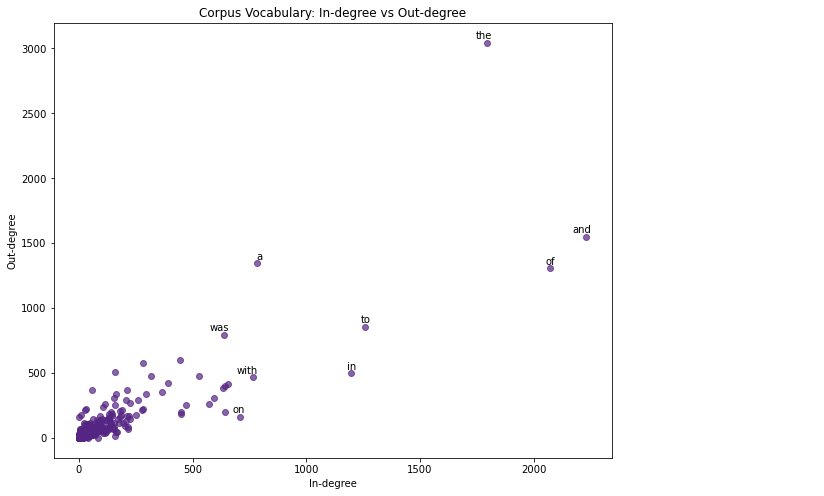

Predicted intercept: 1.0130335143071794
Predicted slope: 0.7889722726030387


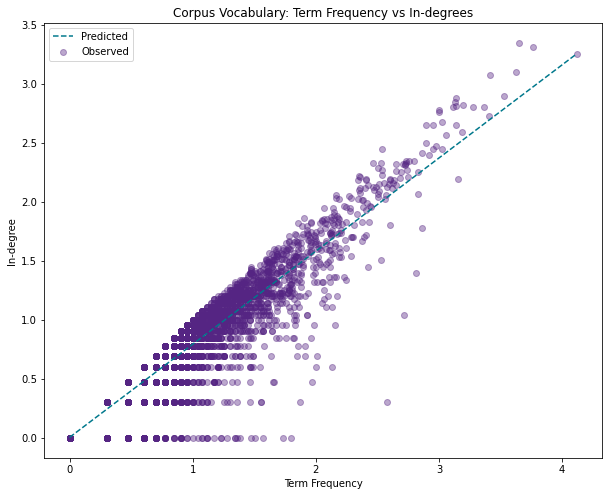

Predicted intercept: 1.0093581450929305
Predicted slope: 0.831302954738056


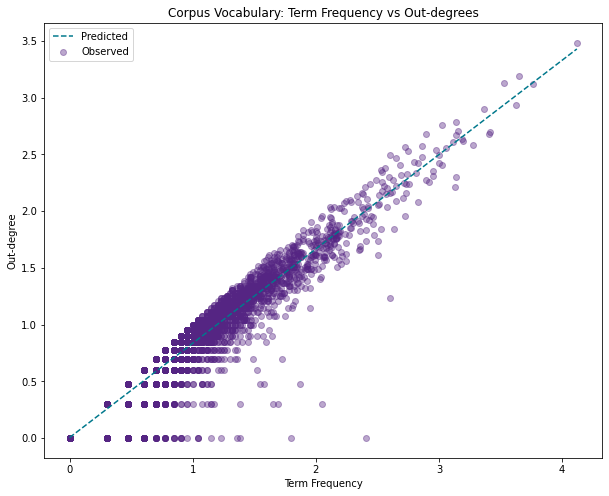

In [8]:
plots_base(vocab_G, 'Corpus Vocabulary')